# ***Penjelasan Dataset Yang Digunakan***

### Dataset yang digunakan dalam penelitian ini merupakan kumpulan data teks yang diekstraksi dari platform media sosial X (sebelumnya Twitter), yang berkaitan dengan isu konflik di Palestina. Dataset ini memuat beberapa atribut, antara lain tautan unggahan, isi teks cuitan, identitas pengguna dalam bentuk nama akun, serta indikator interaksi seperti jumlah likes, retweets, quotes, dan comments. Selain itu, dataset turut dilengkapi dengan label klasifikasi yang merepresentasikan kategori sentimen atau posisi opini terhadap konflik yang dimaksud. Penggunaan dataset ini bertujuan untuk menganalisis pola persepsi publik, kecenderungan opini, serta dinamika penyebaran informasi terkait konflik Palestina melalui jejaring media sosial. Dengan demikian, dataset ini relevan sebagai dasar dalam penerapan metode pemrosesan bahasa alami dan analisis sentimen pada penelitian ini.

In [1]:
!pip install transformers emoji nltk matplotlib seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.3 MB/s eta 0:00:00


In [2]:
# Untuk Pengolahan Kata
from transformers import pipeline
import emoji
import re
import nltk
from nltk.corpus import stopwords, words
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

# Untuk pre processing data
from sklearn.model_selection import train_test_split

# Untuk Pemodelan
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import numpy as np
import pandas as pd

import os

# **Data Understanding**

In [4]:
df = pd.read_csv("./DataSet_for_Bert_7387.csv")

In [ ]:
df.drop_duplicates(inplace=True)
df = df.replace(r'^\s*$', np.nan, regex=True)  # Hapus kolom yang semua nilainya NaN
df

,number,link,text,user,likes,quotes,retweets,comments,label,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,https://twitter.com/BabylonBulletin/status/171...,🚨 #BREAKING 🚨 A high-ranking member of Israe...,Babylon Bulletin,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2,https://twitter.com/lixi32730051/status/171769...,#BREAKING The #Palestinian Islamic Resistance ...,Journalist Lixy,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,3,https://twitter.com/ursala_yacoob/status/17176...,"Stop Israel’s atrocities, genocide massacring ...",Ursala Yacoob 🇵🇸🍉,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN
3,4,https://twitter.com/ellisonbarber/status/17176...,If the walls of #Gaza’s Al Shifa hospital coul...,Ellison Barber,50,4,21,14,1,NaN,NaN,NaN,NaN,NaN
4,5,https://twitter.com/JohnLocker4/status/1717692...,The people of #Gaza needs to kick #HamasNazis ...,💧John Locker,0,0,0,1,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,926,https://twitter.com/iuiccincinnati/status/1803...,Come help #Spread this #Truth to the 4 corners...,IUIC Cincinnati,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN
7383,986,https://twitter.com/networkparty1/status/18035...,"“Hamas is an idea, #Hamas is a party. It’s roo...",GreenPartyNetwork,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN
7384,1033,https://twitter.com/PropagandaBuff/status/1803...,#REUTERSPROPAGANDA #Reuters cited this report ...,Dr. Henry Silverman,0,0,0,0,4,NaN,NaN,NaN,NaN,NaN
7385,1034,https://twitter.com/robertosavard/status/18035...,Hear that great deniers & unconditional defend...,Robert Savard TheMexiCan,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df.isna().sum())
print(df.isnull().sum())
print(df.duplicated().sum())

number      0
link        0
text        0
user        1
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64
number      0
link        0
text        0
user        1
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64
0


In [6]:
df.dropna(subset=['user'], inplace=True)

# Verifikasi bahwa nilai yang hilang sudah dihilangkan
print(df.isna().sum())

number      0
link        0
text        0
user        0
likes       0
quotes      0
retweets    0
comments    0
label       0
dtype: int64


In [7]:
# Calculate the character length of the original 'text' column
df['text_length_char'] = df['text'].apply(lambda x: len(str(x)))

# Calculate the character length of the 'comments' column
df['comments_length_char'] = df['comments'].apply(lambda x: len(str(x)))

# Calculate the average character length for both columns
average_text_length = df['text_length_char'].mean()
average_comments_length = df['comments_length_char'].mean()

print(f"Panjang rata-rata karakter pada kolom 'text': {average_text_length:.2f}")
print(f"Panjang rata-rata karakter pada kolom 'comments': {average_comments_length:.2f}")

Panjang rata-rata karakter pada kolom 'text': 197.35
Panjang rata-rata karakter pada kolom 'comments': 1.02


In [8]:
# Menggunakan .shape
num_rows_shape = df.shape[0]
print(f"Jumlah baris data menggunakan .shape: {num_rows_shape}")

# Menggunakan len()
num_rows_len = len(df)
print(f"Jumlah baris data menggunakan len(): {num_rows_len}")

Jumlah baris data menggunakan .shape: 7386
Jumlah baris data menggunakan len(): 7386


## **Data Text Processing**

Tokenization

In [9]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
# Tokenisasi kolom 'text'
df['text_tokens'] = df['text'].apply(lambda x: tokenizer.tokenize(str(x)))

# Tampilkan beberapa baris hasil tokenisasi untuk verifikasi
print("Tokenisasi kolom 'text':")
display(df[['text', 'text_tokens']].head())

Tokenisasi kolom 'text':


,text,text_tokens
0,🚨 #BREAKING 🚨 A high-ranking member of Israe...,"[BREAKING, A, high, ranking, member, of, Israe..."
1,#BREAKING The #Palestinian Islamic Resistance ...,"[BREAKING, The, Palestinian, Islamic, Resistan..."
2,"Stop Israel’s atrocities, genocide massacring ...","[Stop, Israel, s, atrocities, genocide, massac..."
3,If the walls of #Gaza’s Al Shifa hospital coul...,"[If, the, walls, of, Gaza, s, Al, Shifa, hospi..."
4,The people of #Gaza needs to kick #HamasNazis ...,"[The, people, of, Gaza, needs, to, kick, Hamas..."


Lemmatization

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd # Import pandas to load the dataframe
from nltk.tokenize import RegexpTokenizer # Import RegexpTokenizer

# --- Load Data and Tokenize (Added) ---
try:
    df = pd.read_csv("./DataSet_for_Bert_7387.csv")
    df.drop_duplicates(inplace=True)
    # Assuming other initial processing steps like handling NaNs in 'user' are needed
    df.dropna(subset=['user'], inplace=True) # Add this based on previous cells

    # Tokenization (from cell x5RTzpu8cXth)
    tokenizer = RegexpTokenizer(r'\w+')
    df['text_tokens'] = df['text'].apply(lambda x: tokenizer.tokenize(str(x)))

except FileNotFoundError:
    print("Error: 'DataSet_for_Bert_7387.csv' not found. Please make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading or tokenization: {e}")
    exit()
# --- End Load Data and Tokenize ---


# Download WordNet if not already downloaded
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()


# 1. Aturan Normalisasi Final
lemma_exceptions = {'hamas'}
lemma_map = {
    'hama': 'hamas',
    'israeli': 'israel',
    'israelis': 'israel',
    'palestinian': 'palestine',
    'palestinians': 'palestine'
}

# 2. Fungsi Lemmatization
def lemmatize_tokens(tokens):
    lemmatized_list = []
    for word in tokens:
        word_lower = word.lower()
        if word_lower in lemma_exceptions:
            lemmatized_list.append(word)
        elif word_lower in lemma_map:
            lemmatized_list.append(lemma_map[word_lower])
        else:
            lemmatized_list.append(lemmatizer.lemmatize(word))
    return lemmatized_list

# 3. Terapkan
df['text_lemmatized'] = df['text_tokens'].apply(lemmatize_tokens)

print("Sel 1: Lemmatization Selesai.")
display(df[['text_tokens', 'text_lemmatized']].head(2))

[nltk_data] Downloading package wordnet to /root/nltk_data...


Sel 1: Lemmatization Selesai.


,text_tokens,text_lemmatized
0,"[BREAKING, A, high, ranking, member, of, Israe...","[BREAKING, A, high, ranking, member, of, israe..."
1,"[BREAKING, The, Palestinian, Islamic, Resistan...","[BREAKING, The, palestine, Islamic, Resistance..."


Stopword

In [12]:
import nltk
from nltk.corpus import stopwords
import pandas as pd # Import pandas to ensure df is available

# --- NLTK Downloads and Initialization (Added) ---
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Initialize stop_words
stop_words = set(stopwords.words('english'))
# --- End NLTK Downloads and Initialization ---


# (Asumsi 'stop_words' NLTK sudah di-load) - This comment is now addressed by the added code

# 1. Daftar Stopword Kustom Final (semua huruf kecil)
custom_stop_words = {
    'wa', 'idf', 'ha', 'say', 'said', 'make', 'must', 'still', 'call', 'even',
    'need', 'keep', 'want', 'go', 'give', 'get', 'come', 'see', 'tell', 'look',
    'know', 'think', 'let', 'stop', 'use', 'used', 'take', 'put', 'mean',
    'one', 'people', 'day', 'time', 'year', 'way', 'part', 'thing', 'life', 'world',
    'group', 'number', 'many', 'another', 'work', 'back', 'well', 'really', 'amp',
    'video', 'youtube', 'via', 'online', 'read', 'news', 'post', 'tweet',
    'breaking', 'live', 'feed_id', 'us', 'also', 'like', 'good', 'new', 'much',
    'right', 'action', 'hope', 'may', 'never', 'every', 'always', 'going',
    'talk', 'watch', 'show', 'report', 'article', 'medium', 'please', 'thank',
    'god', 'love', 'without', 'nothing', 'piped', 'ceasefirenow', 'wordwar', 'si', 'two', 'im', 'de', 'le', 'un',
    'doe', 'yet', 'org', 'short', 'first', 'end', 'face', 'continue', 'called',
    'last', 'made', 'city', 'word', 'help', 'money', 'home', 'plan', 'power',
    'real', 'evil', 'newsonlineread', 'today', 'start', 'stand', 'calling',
    'full', 'share', 'lie', 'everyone', 'already', 'story', 'history', 'point',
    'place', 'care', 'name', 'full', 'lost',
    '_unique_id', 'unique_id', 'gazagenocide', 'freepalestine', 'gazagaza', 'gaza_genocide'
}

# 2. Gabungkan Daftar Stopword
all_words_to_remove = stop_words.union(custom_stop_words)

# 3. Terapkan Filter
# Assuming 'text_lemmatized' column exists from the previous cell
df['text_cleaned'] = df['text_lemmatized'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in all_words_to_remove and len(word) > 1]
)

print("Sel 2: Stopword Removal Selesai.")
display(df[['text_lemmatized', 'text_cleaned']].head(2))

Sel 2: Stopword Removal Selesai.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_lemmatized,text_cleaned
0,"[BREAKING, A, high, ranking, member, of, israe...","[high, ranking, member, israel, special, force..."
1,"[BREAKING, The, palestine, Islamic, Resistance...","[palestine, Islamic, Resistance, Movement, Ham..."


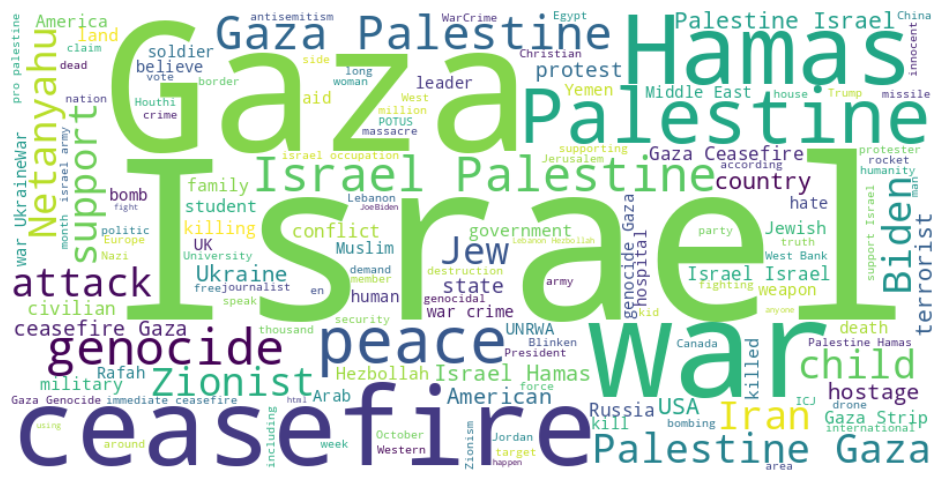

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Siapkan data dari kolom 'text_cleaned'
try:
    text_series = df['text_cleaned'].apply(lambda tokens: ' '.join(tokens))
    all_text = ' '.join(text_series)

    # 2. Periksa apakah teks kosong (jika filter terlalu agresif)
    if not all_text.strip():
        print("Error: Teks yang sudah dibersihkan kosong.")
    else:
        # 3. Buat dan tampilkan word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=150
        ).generate(all_text)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

except KeyError:
    print("Error: Pastikan kolom 'text_cleaned' ada di DataFrame 'df' Anda.")
except Exception as e:
    print(f"Terjadi error: {e}")

Labeling

In [14]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [15]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- Configuration ---
# !!! IMPORTANT: Change this to your DataFrame's original text column name
ORIGINAL_TEXT_COLUMN = 'text'
# ---

# 1. Initialize VADER
sia = SentimentIntensityAnalyzer()

# 2. Define helper functions
def get_vader_compound_score(text):
    """Returns the compound polarity score (-1.0 to +1.0)"""
    if isinstance(text, float): # Handle empty/nan values
        return 0.0
    return sia.polarity_scores(text)['compound']

def get_sentiment_label(compound_score):
    """Classifies a compound score into a category"""
    if compound_score >= 0.05:
        return 'Positif'
    elif compound_score <= -0.05:
        return 'Negatif'
    else:
        return 'Netral'

# --- Execution ---
print("Starting VADER sentiment labeling...")

# 3. Create 'polarity_score' column from the original text
df['polarity_score'] = df[ORIGINAL_TEXT_COLUMN].apply(get_vader_compound_score)

# 4. Create 'sentiment_label' column from the polarity score
df['sentiment_label'] = df['polarity_score'].apply(get_sentiment_label)

print("Sentiment labeling complete.")

# 5. Display verification
print("\nDataFrame with new sentiment columns:")
display(df[[ORIGINAL_TEXT_COLUMN, 'likes', 'retweets', 'polarity_score', 'sentiment_label']].head())

# 6. Display distribution
print("\nNew Sentiment Label Distribution:")
display(df['sentiment_label'].value_counts())

Starting VADER sentiment labeling...
Sentiment labeling complete.

DataFrame with new sentiment columns:


,text,likes,retweets,polarity_score,sentiment_label
0,🚨 #BREAKING 🚨 A high-ranking member of Israe...,2,0,0.4019,Positif
1,#BREAKING The #Palestinian Islamic Resistance ...,1,0,-0.8020,Negatif
2,"Stop Israel’s atrocities, genocide massacring ...",0,1,0.0516,Positif
3,If the walls of #Gaza’s Al Shifa hospital coul...,50,21,-0.4824,Negatif
4,The people of #Gaza needs to kick #HamasNazis ...,0,0,-0.9274,Negatif



New Sentiment Label Distribution:


,count
sentiment_label,
Negatif,3952
Positif,2352
Netral,1082


Vectorization & Splitting

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# --- Pre-processing for Vectorizer ---
# TF-IDF expects strings, not lists of tokens. We must join our 'text_cleaned' list.
# We also handle any potential empty/nan values.
def join_tokens(tokens):
    if isinstance(tokens, list):
        return ' '.join(tokens)
    return '' # Return empty string for 'nan' or other types

df['text_cleaned_string'] = df['text_cleaned'].apply(join_tokens)


# --- Step 8: Text Vectorization (TF-IDF) ---

print("Starting Step 8: Text Vectorization (TF-IDF)...")

# 1. Define X (features) and y (target)
X = df['text_cleaned_string']  # Feature: our cleaned text
y = df['sentiment_label']      # Target: our VADER labels

# 2. Initialize and run TF-IDF Vectorizer
# We limit to 5000 most common words (max_features)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

print(f"Vectorization complete. Matrix shape: {X_tfidf.shape}")


# --- Step 9: Data Splitting ---

print("\nStarting Step 9: Data Splitting (80/20)...")

# 3. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,    # 20% of data for testing
    random_state=42   # For reproducible results
)

print("Data splitting complete.")

# 4. Show the results
print("\n--- Results ---")
print(f"Total data: {X_tfidf.shape[0]}")
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")

Starting Step 8: Text Vectorization (TF-IDF)...
Vectorization complete. Matrix shape: (7386, 5000)

Starting Step 9: Data Splitting (80/20)...
Data splitting complete.

--- Results ---
Total data: 7386
Training data shape (X_train): (5908, 5000)
Testing data shape (X_test): (1478, 5000)
Training labels shape (y_train): (5908,)
Testing labels shape (y_test): (1478,)


# **Data Modeling**

In [17]:
from sklearn.naive_bayes import MultinomialNB

# (Variabel X_train, y_train, X_test, y_test sudah ada dari sel sebelumnya)

print("Memulai Langkah 10: Data Modeling...")

# 1. Inisialisasi Model
# Kita akan menggunakan Multinomial Naive Bayes
model = MultinomialNB()

# 2. Latih Model (Proses "Belajar")
# Model akan "belajar" pola dari data latih (X_train, y_train)
print("Melatih model pada 5908 data latih...")
model.fit(X_train, y_train)

print("Model training complete!")
print("\nModel Anda sekarang siap untuk dievaluasi.")

Memulai Langkah 10: Data Modeling...
Melatih model pada 5908 data latih...
Model training complete!

Model Anda sekarang siap untuk dievaluasi.


# Data Evaluasi

Starting Step 11: Data Evaluation...
Making predictions on 1478 test data points...
Predictions complete.

--- Classification Report ---
              precision    recall  f1-score   support

     Negatif       0.63      0.94      0.75       814
      Netral       1.00      0.00      0.01       218
     Positif       0.73      0.41      0.53       446

    accuracy                           0.65      1478
   macro avg       0.79      0.45      0.43      1478
weighted avg       0.71      0.65      0.58      1478


--- Confusion Matrix ---


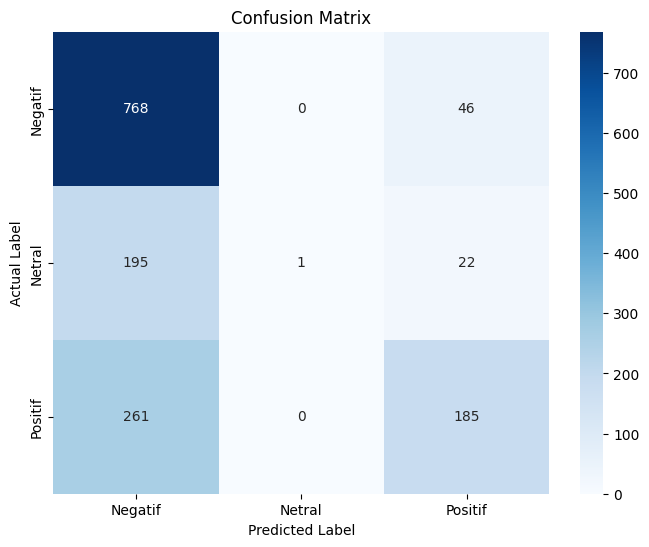

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# (Variables 'model', 'X_test', and 'y_test' already exist from the previous cell)

print("Starting Step 11: Data Evaluation...")

# 1. Make Predictions
# Ask the model to guess the labels for the unseen test data (X_test)
print("Making predictions on 1478 test data points...")
y_pred = model.predict(X_test)

print("Predictions complete.")

# 2. Generate Classification Report
# This compares the predictions (y_pred) with the true answers (y_test)
print("\n--- Classification Report ---")
# 'zero_division=0' prevents errors if a label has no predictions
print(classification_report(y_test, y_pred, zero_division=0))


# 3. Generate Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# Get the unique labels (e.g., Negative, Neutral, Positive)
labels = sorted(y_test.unique())

# Plotting with Seaborn for a clearer visual
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Data Prediksi

In [20]:
import nltk
# Download 'punkt_tab' for tokenization
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Download 'punkt' for tokenization, just in case
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize

# (This cell assumes 'lemmatize_tokens', 'all_words_to_remove', 'vectorizer',
# and 'model' exist in memory from the previous cells)

print("Starting Step 12: Data Prediction...")

# 1. Create some new, unseen sample posts
new_posts = [
    "This is a terrible war. I hope it ends soon.",
    "I just saw a report on UNRWA, it is very good news.",
    "Biden and Netanyahu must push for peace.",
    "This is just a protest, nothing more."
]

print(f"Predicting sentiment for {len(new_posts)} new posts...\n")

# 2. Loop through each new post and apply the full pipeline
for raw_text in new_posts:

    # Step 1: Tokenize
    tokens = word_tokenize(raw_text)

    # Step 2: Lemmatize (using the function from Cell 1)
    lemmatized_tokens = lemmatize_tokens(tokens)

    # Step 3: Stopword Removal (using the list from Cell 2)
    cleaned_tokens = [
        word for word in lemmatized_tokens
        if word.lower() not in all_words_to_remove and len(word) > 1
    ]

    # Step 4: Join into a single string
    final_string = ' '.join(cleaned_tokens)

    # Step 5: Vectorize (using the vectorizer from Cell 3)
    # We use .transform() [not .fit_transform()]
    vector = vectorizer.transform([final_string])

    # Step 6: Predict (using the model from Cell 4)
    prediction = model.predict(vector)

    # --- Display Result ---
    print(f"Original Text: {raw_text}")
    print(f"Cleaned Text: {final_string}")
    print(f"Predicted Sentiment: {prediction[0]}")
    print("-" * 30)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Starting Step 12: Data Prediction...
Predicting sentiment for 4 new posts...

Original Text: This is a terrible war. I hope it ends soon.
Cleaned Text: terrible war soon
Predicted Sentiment: Negatif
------------------------------
Original Text: I just saw a report on UNRWA, it is very good news.
Cleaned Text: saw UNRWA
Predicted Sentiment: Negatif
------------------------------
Original Text: Biden and Netanyahu must push for peace.
Cleaned Text: Biden Netanyahu push peace
Predicted Sentiment: Negatif
------------------------------
Original Text: This is just a protest, nothing more.
Cleaned Text: protest
Predicted Sentiment: Negatif
------------------------------
